# Model for Pneumonia detection

## Purpose of this projet is to build a model for detecting pneumonia based of the chest X-ray

## Data: Following Dataset is available

1) There are image files in DICOM format.

2) stage_2_train_labels.csv. this has patient id and the object information (x,y,height, width) and label that indicates whether patient has pneumonia or NO?

3) stage_2_detailed_class_info.csv. this file has the patient id and the lung condition whether it is normal and/ or opaque.

A DICOM file consists of a header and image data sets packed into a single file. The information within the header is organized as a constant and standardized series of tags. By extracting data from these tags one can access important information regarding the patient demographics, study parameters, etc.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
from zipfile import ZipFile
import os
from tqdm import tqdm

In [5]:
#images_path="/content/drive/MyDrive/AIML/capstone/rsna-pneumonia-detection-challenge.zip"

In [6]:
#os.chdir('/content/drive/MyDrive/AIML/capstone')

In [170]:
import numpy as np
import pandas as pd
import seaborn as sns
import pydicom as dcm
import math
import cv2
from glob import glob
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [175]:
# Importing libraries for model building


from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense, LeakyReLU,Dropout
from tensorflow.keras.layers import  Activation,MaxPooling2D,BatchNormalization
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D


import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnetProcess_input

#import tensorflow
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler


from tensorflow.keras import losses,optimizers, regularizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

import scipy.stats as stats 

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import r2_score

from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.callbacks import EarlyStopping

from keras.layers import Conv2D # swipe across the image by 1
#from keras.layers import MaxPooling2D # swipe across by pool size
#from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
## Reading the labels dataset and showing the first few records from data
#Patient_RecordInfo = pd.read_csv("/content/drive/MyDrive/AIML/capstone/stage_2_train_labels.csv")
Patient_RecordInfo = pd.read_csv("stage_2_train_labels.csv")

Patient_RecordInfo.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


 Observations: 

Target = 1 indicates pneumonia is detected and target = 0 indicates pneumonia not detected.

For the rows where when target = 0, columns x,y,width and depth values are Nan

In [10]:
Patient_RecordInfo.info()
## There are 30227 patientID .
## There are 30277 target values.
## x ,y, WIdth and height non null count is 9555 , The others are null.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [11]:
#There are 30227 records and 6 columns

Patient_RecordInfo.shape

(30227, 6)

In [12]:
Patient_RecordInfo.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


#After analyzing the "stage_2_train_labels.csv" the patient with Traget values '1' are having medical records with Pneumonia and

#Patients with Traget Value '0' are having no medical records and can be consider as 'non-Penumonia' Patients.

Lets find the number of Patients who are having Pneoumonia with Traget Value '1'

In [119]:
Patient_RecordInfo.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

Lets find the number of Patients who are Non-Pneoumonia  Traget Value '0'

Lets Differntiate the Patients with help of Pie-Chart

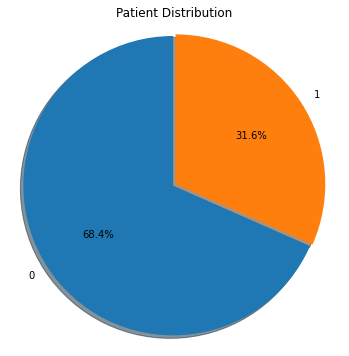

In [15]:
label_count=Patient_RecordInfo['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Patient Distribution')
plt.show()

In [16]:
#Check for duplicate records in the data set

duplicate = Patient_RecordInfo[Patient_RecordInfo.duplicated()]

In [17]:
#Lets check for whether any duplicate patients records are there.

duplicate_PatientRecords = Patient_RecordInfo[Patient_RecordInfo.duplicated(['patientId'])]

In [18]:
duplicate_PatientRecords

,patientId,x,y,width,height,Target
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1
20,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1
...,...,...,...,...,...,...
30209,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,295.0,473.0,133.0,176.0,1
30215,c1cddf32-b957-4753-acaa-472ab1447e86,766.0,475.0,135.0,213.0,1
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,316.0,504.0,179.0,273.0,1
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1


There are 3542 duplicate rows

In [19]:
duplicate_PatientRecords.head(4)

,patientId,x,y,width,height,Target
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1


lets take one duplicate Patient record and find the difference

In [20]:
Patient_RecordInfo[Patient_RecordInfo.patientId=='c1f7889a-9ea9-4acb-b64c-b737c929599a']

,patientId,x,y,width,height,Target
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1
30226,c1f7889a-9ea9-4acb-b64c-b737c929599a,233.0,424.0,201.0,356.0,1


From the above result the patient ids are same but the records are diffrent in terms of Xray dimensions

## EDA on stage_2_detailed_class_info training dataset**


In [21]:
# Pneumonia_ClassInfo= pd.read_csv("/content/drive/MyDrive/AIML/capstone/stage_2_detailed_class_info.csv")
Pneumonia_ClassInfo= pd.read_csv("stage_2_detailed_class_info.csv")

Pneumonia_ClassInfo.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [22]:
Pneumonia_ClassInfo.shape

(30227, 2)

lets Check for Null values in the data set

In [23]:
Pneumonia_ClassInfo.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


From the above there are no null columns in the dataSet

Lets find the count of the classes

In [24]:
Pneumonia_ClassInfo['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


#11821 ---------->No Lung Opacity / Not Normal

#8851 -----------> Normal

#9555 -----------> Lung Opacity

lets Visualize the Class Info in Pie Chart

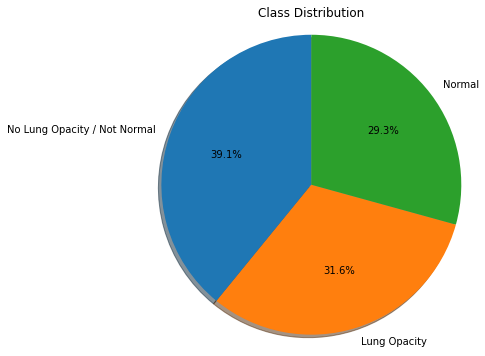

In [25]:
label_count=Pneumonia_ClassInfo['class'].value_counts()

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(label_count.values, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

#Lets check for patients with Duplicate records in Class info data set.

In [26]:
duplicate = Pneumonia_ClassInfo[Pneumonia_ClassInfo.duplicated(['patientId'])]

duplicate

,patientId,class
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
15,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity
17,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity
20,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity
...,...,...
30209,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,Lung Opacity
30215,c1cddf32-b957-4753-acaa-472ab1447e86,Lung Opacity
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity


In [27]:
Pneumonia_ClassInfo.duplicated(subset=['patientId', 'class']).sum()

3543

#From the above there are 3543 row having the same set of records

In [28]:
Pneumonia_ClassInfo[Pneumonia_ClassInfo.patientId=='c1f7889a-9ea9-4acb-b64c-b737c929599a']

,patientId,class
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity
30226,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


In [29]:
Pneumonia_ClassInfo.shape

(30227, 2)

## Merging the Patient_RecordInfo and Pneumonia_ClassInfo data set into training dataset**


In [30]:
# Form a final data set with ' Patient_RecordInfo' and 'Pneumonia_ClassInfo':
Pneumonia_DataFrame = pd.concat([Patient_RecordInfo, Pneumonia_ClassInfo['class']], axis = 1)

Pneumonia_DataFrame.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [123]:
# checking the
pivot = np.round(pd.pivot_table(Pneumonia_DataFrame, values='patientId', 
                                index='Target', 
                                columns='class', aggfunc=np.any),2)

In [124]:
pivot

class,Lung Opacity,No Lung Opacity / Not Normal,Normal
Target,,,
0,NaN,True,True
1,True,NaN,NaN


### Observations:
#### Patients for whom pneumonia is detected, the class label is 'Lung opacity'
#### Patients with no pneumonia has class label either 'Normal' or 'No lung Opacity/ Not normal'
#### There is no overlap here

In [32]:
trainpath="D:\\Googledrive\\GreatLearning\\Capstone project\\Dataset\\pnm\\stage_2_train_images\\"
testpath="D:\\Googledrive\\GreatLearning\\Capstone project\\Dataset\\pnm\\stage_2_test_images\\"

In [120]:
## ANALYSING THE DICOM IMAGE FILES
# Following function will read and the display the 9 image in 3x3 figue along with corresponding metadata

def check_img(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = trainpath+"{}.dcm".format(patientImage)
        print(dcm_file)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

Displaying Chest Xray Images of Patients who have Pneuomina

D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\31bb6549-ca98-4586-b5d6-b0e9142e6ae2.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\b3406349-2336-4782-8f9a-dd2e2f731d7b.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\b64e0ee1-82db-47fa-a91a-f1e187f84696.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\7f44bc68-029e-4c1f-ad3a-9c020086afb0.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\741500a4-d128-4b85-852b-428779f5c5ec.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\32e6fd38-0e31-450c-93ec-f29ea5a6ad2c.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\3c319790-02cd-44d7-bb91-8e758463ac82.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\ec885fc7-04cc-47a5-b971-11ef284c229f.dcm
D:\Googledrive\GreatLearning\Capstone pr

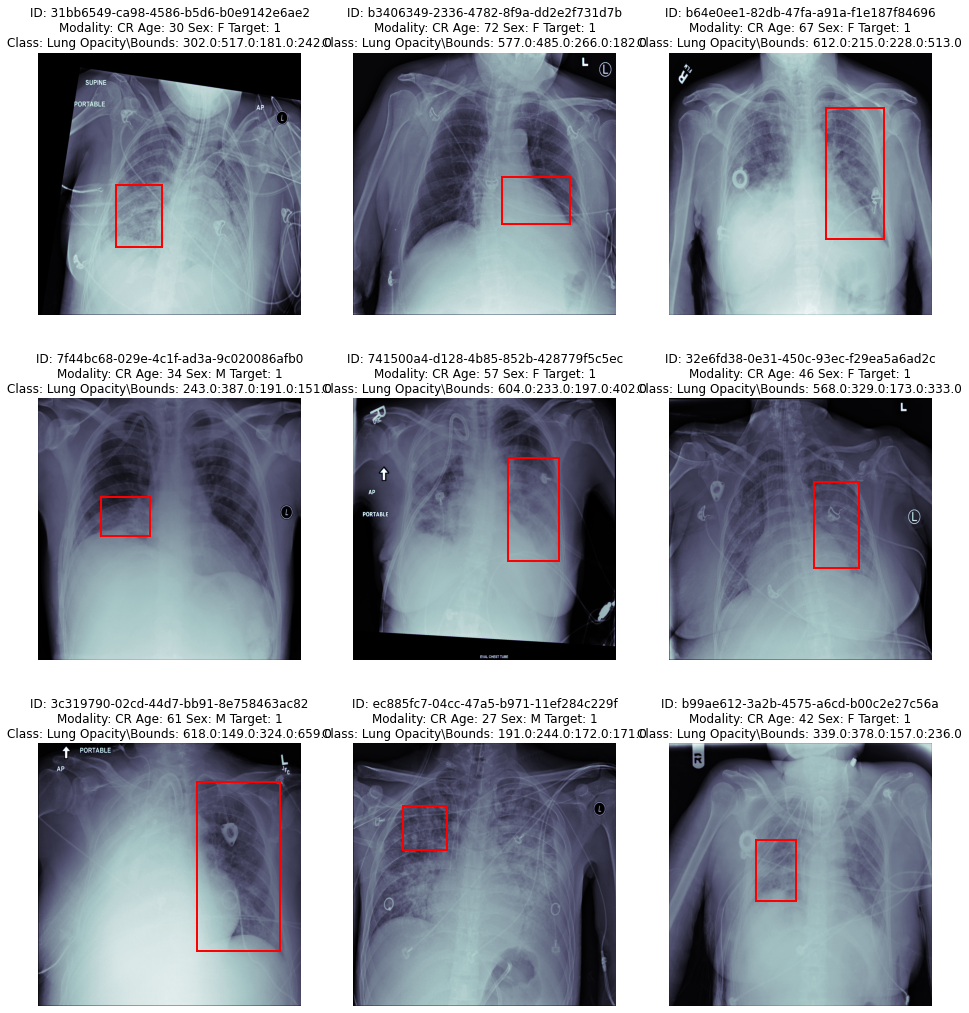

In [121]:
## Checking few images which has Pneumonia 
check_img(Pneumonia_DataFrame[Pneumonia_DataFrame['Target']==1].sample(9))

### Observation: The above nine images shows the bounding box with region where opacity is detected in X-ray

D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\b1dda51c-9c0e-4695-bd29-e7173f05182d.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\ea32dd2a-6106-4df1-af7e-ce64401a4010.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\9f63f132-7293-46cd-ab0b-ef1ed9754806.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\e33f2a56-329a-4f88-9b38-ed09ecfb9fd6.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\646c5605-7233-42a8-b190-0fe199e7d2d4.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\de2479ba-0b61-400f-978b-86a2d1b7a480.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\db26b992-3f94-4f49-a549-64b73527356f.dcm
D:\Googledrive\GreatLearning\Capstone project\Dataset\pnm\stage_2_train_images\96b48c09-f6d4-463d-a8df-6179f4e53d44.dcm
D:\Googledrive\GreatLearning\Capstone pr

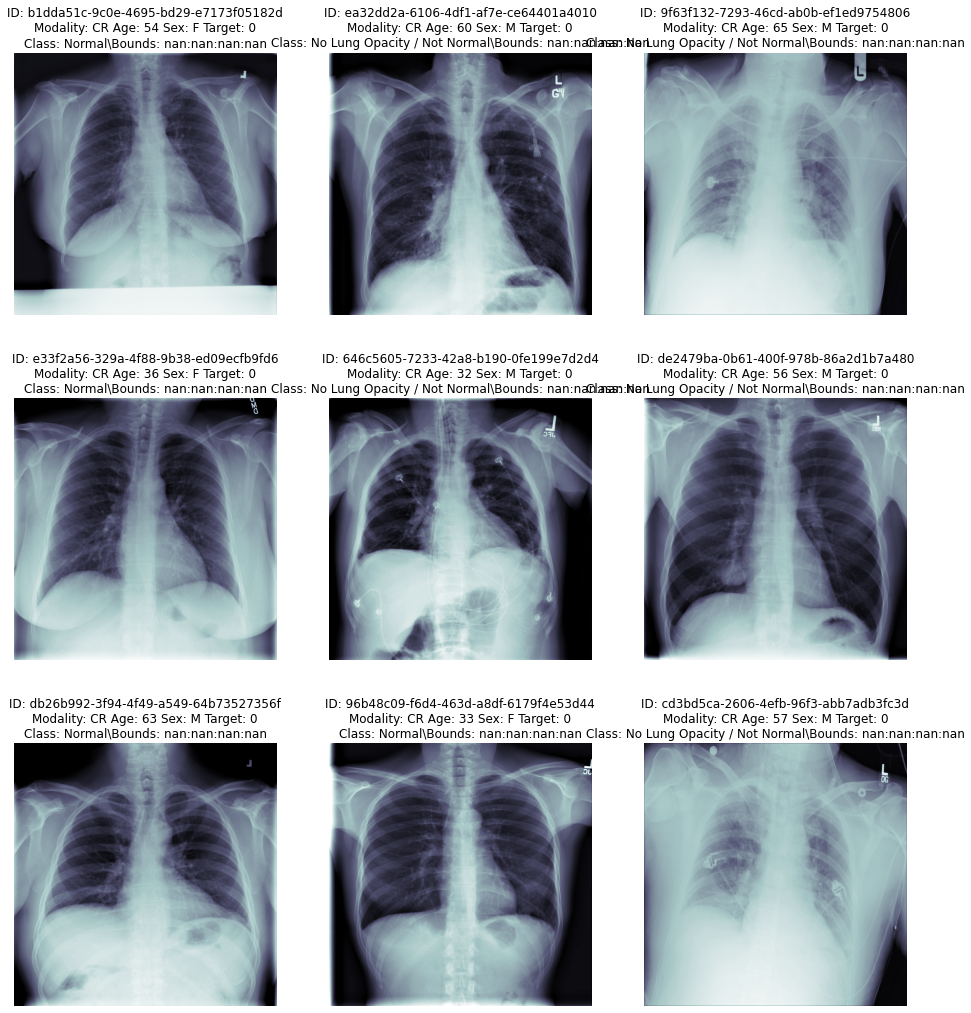

In [122]:
## Checking few of the  images which does not have pneumonia 
check_img(Pneumonia_DataFrame[Pneumonia_DataFrame['Target']==0].sample(9))

### Observation: The above images shows the X-Ray of with patients with no pneumonia. there is no opacity detected

### Reading the Dicom images meta data and appending it to the training set

In [36]:
## DCIM image contains the meta data along with it which we can use, 
## Function to read the DCIM data and appending to the resultset
def funcDCIMData(rowData):
    dcm_file = trainpath+'{}.dcm'.format(rowData.patientId)
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge

In [315]:
## Reading the metadata from images and append it to the training_data dataset
Pneumonia_DataFrame['sex'], Pneumonia_DataFrame['age'] = zip(*Pneumonia_DataFrame.apply(funcDCIMData, axis=1))

In [69]:
Pneumonia_DataFrame.info()
## There are 30227  records
## Sex and Age also have the same count indicating that there are no image missing and every patient has an DICOM image 
## Age should be a numeric , currently it is an object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  30227 non-null  int64  
 1   patientId   30227 non-null  object 
 2   x           9555 non-null   float64
 3   y           9555 non-null   float64
 4   width       9555 non-null   float64
 5   height      9555 non-null   float64
 6   Target      30227 non-null  int64  
 7   class       30227 non-null  object 
 8   sex         30227 non-null  object 
 9   age         30227 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 2.3+ MB


In [38]:
# Converting age to Numeric form as the current data type is a String
Pneumonia_DataFrame['age'] = Pneumonia_DataFrame.age.astype(int)

In [39]:
Pneumonia_DataFrame.to_csv("Pneumonia_DataFrameAB.csv")

In [126]:
# loading the csv file creaed earlier. this step is done in order to avoid repiting the step which is 
## very resouce intensive
# purpose is to save time of reading metadata from the images
Pneumonia_DataFrame=pd.read_csv("Pneumonia_DataFrameAB.csv")

In [41]:
Pneumonia_DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  30227 non-null  int64  
 1   patientId   30227 non-null  object 
 2   x           9555 non-null   float64
 3   y           9555 non-null   float64
 4   width       9555 non-null   float64
 5   height      9555 non-null   float64
 6   Target      30227 non-null  int64  
 7   class       30227 non-null  object 
 8   sex         30227 non-null  object 
 9   age         30227 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 2.3+ MB


In [42]:
Pneumonia_DataFrame.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,30227.0,NaN,NaN,NaN,15113.0,8725.92763,0.0,7556.5,15113.0,22669.5,30226.0
patientId,30227,26684,3239951b-6211-4290-b237-3d9ad17176db,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x,9555.0,NaN,NaN,NaN,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,NaN,NaN,NaN,366.83956,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,NaN,NaN,NaN,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,NaN,NaN,NaN,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,30227.0,NaN,NaN,NaN,0.316108,0.464963,0.0,0.0,0.0,1.0,1.0
class,30227,3,No Lung Opacity / Not Normal,11821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,30227,2,M,17216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,30227.0,NaN,NaN,NaN,46.797764,16.89294,1.0,34.0,49.0,59.0,155.0


In [ ]:
## The mean age is 46.8 years, where as minimum age is 1 year and the max age is 155 which seems to be an outlier.
## 50% of the patients are of approx. 49 age , 
## the standard deviation is 16 which suggest that age is not normally distubuted

In [43]:
Pneumonia_DataFrame.sex.value_counts()
## There are only two gender types

M    17216
F    13011
Name: sex, dtype: int64

Text(0.5, 1.0, 'Sex and Target for Chest Exams')

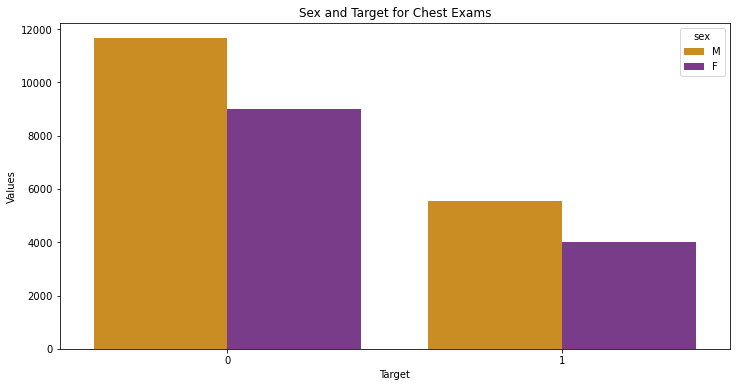

In [44]:
## Distbution of Sex among the targets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = Pneumonia_DataFrame.groupby('Target')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'sex', data = data_target_class, palette = 'CMRmap_r')
plt.title('Sex and Target for Chest Exams')

## the number of males in both category are higher than women

Text(0.5, 1.0, 'Sex and class for Chest Exams')

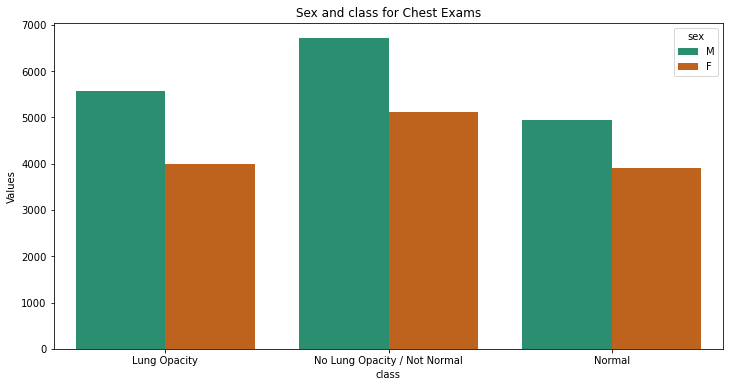

In [45]:
## Distbution of Sex Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = Pneumonia_DataFrame.groupby('class')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Dark2')
plt.title('Sex and class for Chest Exams')

## Number of males in all classes are higher than number of women

<AxesSubplot:xlabel='age', ylabel='Density'>

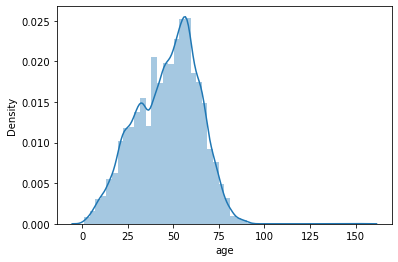

In [46]:
sns.distplot(Pneumonia_DataFrame.age) 
# plots the distrubution of age
## Looks like normal distubution of age

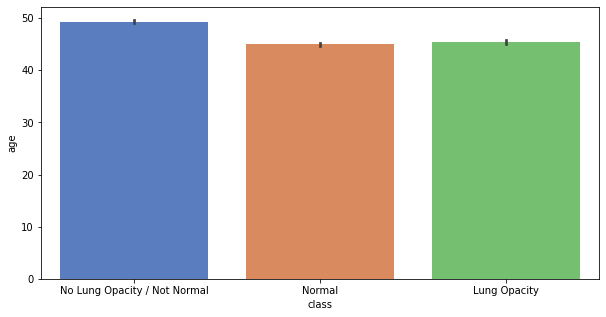

In [79]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='class', y='age', data=Pneumonia_DataFrame, palette='BuPu')  # barplot'
## This is the distubution of Age with class, maximum age of person with pneumonia is around 45

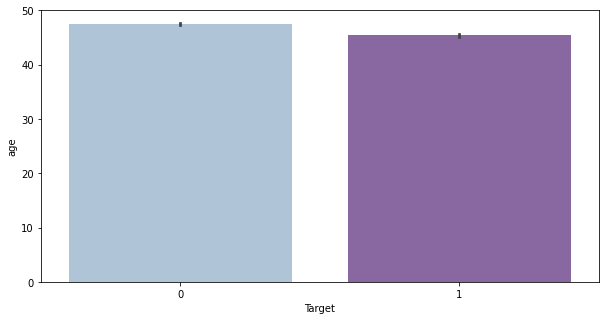

In [47]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='Target', y='age', data=Pneumonia_DataFrame, palette='BuPu')  # barplot'
## This is the distubution of Age with class, maximum age of person with pneumonia is approx 45

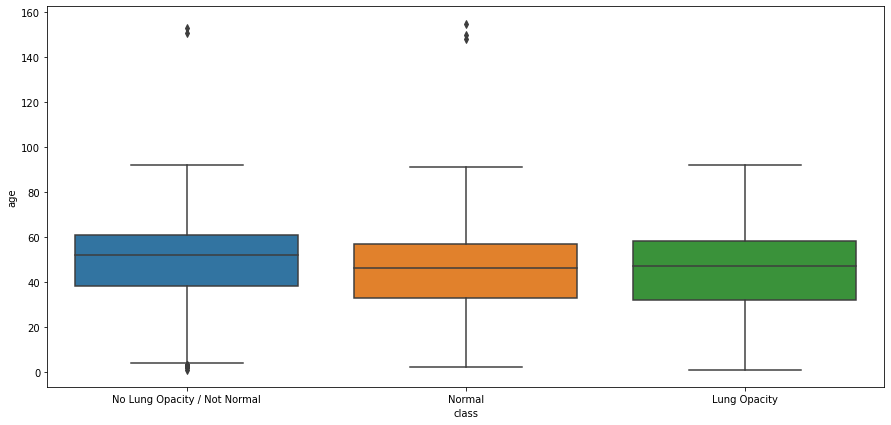

In [48]:
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='age', data= Pneumonia_DataFrame)
plt.show()

## The  class which has no pneumonia has few outliers , their age is approx 150 years

In [150]:
# checking the couunt of patients with age > 120
gt_100 = Pneumonia_DataFrame[Pneumonia_DataFrame['age']>100]
gt_100.shape[0]

5

In [151]:
## There are only 5 patients with age > 100. the same is observed in the box plot. lets ignore these 5 records as of now

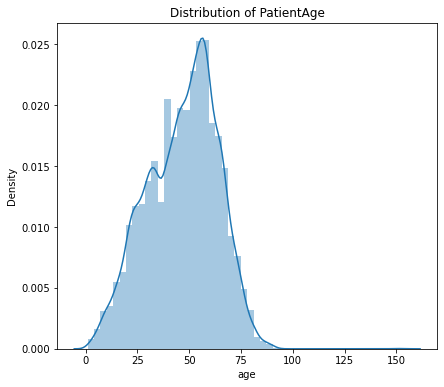

In [146]:
#print('Distribution of `Age`: Overall and Target = 1')
fig = plt.figure(figsize = (15, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(Pneumonia_DataFrame['age']).set_title('Distribution of PatientAge'))

In [152]:
## Overall Distrubution of Age looks normal with very little skew

Distribution of `Age`: Overall and Target = 1


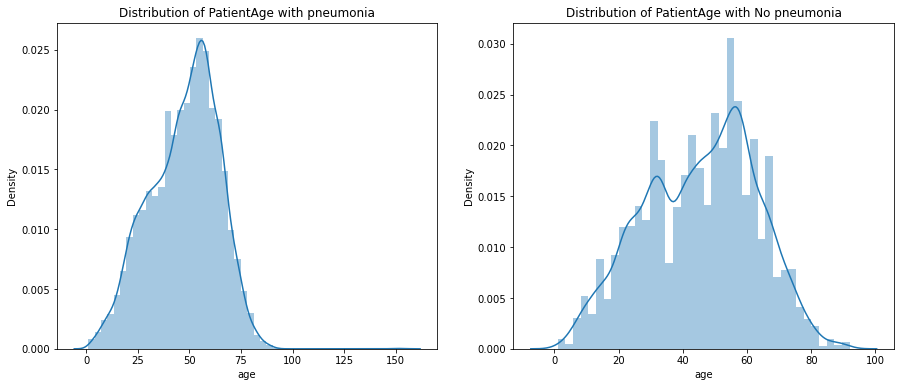

In [144]:
print('Distribution of `Age`: Overall and Target = 1')
fig = plt.figure(figsize = (15, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(Pneumonia_DataFrame.loc[Pneumonia_DataFrame['Target'] == 0, 'age']).set_title('Distribution of PatientAge with pneumonia'))

ax = fig.add_subplot(122)
g = (sns.distplot(Pneumonia_DataFrame.loc[Pneumonia_DataFrame['Target'] == 1, 'age']).set_title('Distribution of PatientAge with No pneumonia'))


In [ ]:
## Distubution of Patients who have penuomonia is slightly skewed 
## Distubution of Patients who have No penuomonia is has two peaks around age 30 and 55

### **MODEL BUILDING**

In [59]:
## Just taking a 800 samples from the dataset
##sample_data = Pneumonia_DataFrame.groupby('class', group_keys=False).apply(lambda x: x.sample(800))

In [60]:
## Just taking a 800 samples from the dataset
sample_data = Pneumonia_DataFrame.sample(2000)

In [80]:
## Checking the training data set with class distbution 
sample_data["class"].value_counts()/2000*100

No Lung Opacity / Not Normal    39.25
Lung Opacity                    31.20
Normal                          29.55
Name: class, dtype: float64

In [81]:
# The distribution in the sample data across three classes is same as the full dataset. 
# i.e. roughly  40% for 'No lung opacity and 30% each for 'other two classes

In [62]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 24795 to 27623
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2000 non-null   int64  
 1   patientId   2000 non-null   object 
 2   x           624 non-null    float64
 3   y           624 non-null    float64
 4   width       624 non-null    float64
 5   height      624 non-null    float64
 6   Target      2000 non-null   int64  
 7   class       2000 non-null   object 
 8   sex         2000 non-null   object 
 9   age         2000 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 171.9+ KB


In [63]:
## Pre Processing the image files

# We preprocess the images to standardize the input, add value to the input data, adjust class labels and add 
# pixel valued arrays to image input

# For the image size, we resize all the images to 128x128 pixel size in order to optimize the input and the processing.
# We also add a total of 3 channels to the images as the dicom images do not have color.
# from tensorflow.keras.applications.mobilenet import preprocess_input

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = trainpath+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels


In [64]:
## Reading the images into numpy array
images,labels = populateImage(sample_data)

In [65]:
#type(images)

In [66]:
type(labels)

numpy.ndarray

In [67]:
images.shape, labels.shape
## The image is of 128*128 with 3 channels

((2000, 128, 128, 3), (2000,))

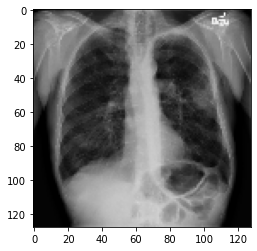

In [154]:
## Checking one of the converted image 
plt.imshow(images[50])

In [69]:
## Checking for unique labels
print(np.unique(labels))
print(len(np.unique(labels)))

['Lung Opacity' 'No Lung Opacity / Not Normal' 'Normal']
3


In [72]:
## Encoding the labels

enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [73]:
## Splitting into train ,test and validation data

X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)


In [74]:
## Function to create a Dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

## Iteration 1

In [75]:
## CNN Model without transfer learning , we start with 32 filters with 5,5 kernal and no padding , then 64 and 128 with drop layers in between 
## And softmax activation as the last layer
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.35))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.35))


  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [76]:
# Model Summary
CNN1 = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [77]:
## Training for 30 epochs with batch size of 30
history1 = CNN1.fit(X_train, 
                  y_train, 
                  epochs = 10, 
                  validation_data = (X_val,y_val),
                  batch_size = 100)

Epoch 1/10
14/14 [==============================] - 125s 9s/step - loss: 9.7243 - accuracy: 0.3736 - val_loss: 1.1007 - val_accuracy: 0.3367
Epoch 2/10
14/14 [==============================] - 119s 9s/step - loss: 1.1402 - accuracy: 0.3586 - val_loss: 1.0816 - val_accuracy: 0.3767
Epoch 3/10
14/14 [==============================] - 118s 8s/step - loss: 1.1024 - accuracy: 0.3757 - val_loss: 1.0984 - val_accuracy: 0.3367
Epoch 4/10
14/14 [==============================] - 119s 9s/step - loss: 1.1120 - accuracy: 0.3886 - val_loss: 1.0628 - val_accuracy: 0.4300
Epoch 5/10
14/14 [==============================] - 118s 8s/step - loss: 1.0934 - accuracy: 0.4064 - val_loss: 1.0647 - val_accuracy: 0.4500
Epoch 6/10
14/14 [==============================] - 118s 8s/step - loss: 1.2767 - accuracy: 0.3979 - val_loss: 1.0785 - val_accuracy: 0.3833
Epoch 7/10
14/14 [==============================] - 118s 8s/step - loss: 1.0729 - accuracy: 0.4079 - val_loss: 1.0788 - val_accuracy: 0.3733
Epoch 8/10
14

In [82]:
## evalualting the accuracy , we have only got accuracy of 36-40% where as the training accuracy is around 40%
fcl_loss, fcl_accuracy = CNN1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

10/10 [==============================] - 5s 502ms/step - loss: 1.0752 - accuracy: 0.3633
Test loss: 1.0751755237579346
Test accuracy: 0.3633333444595337


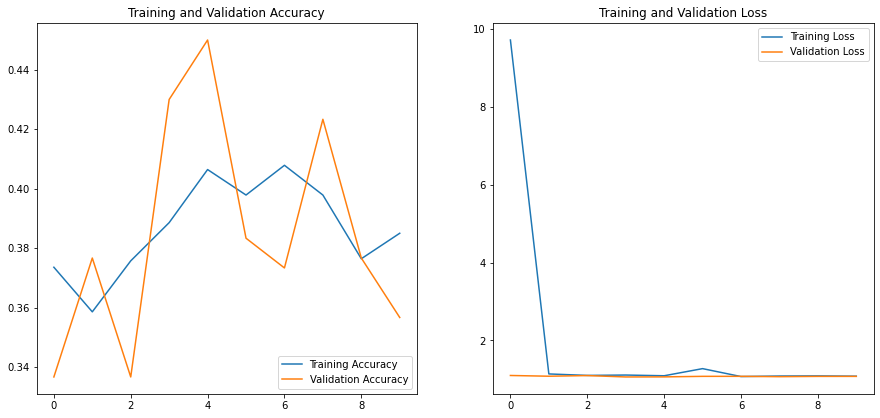

In [83]:
## PLottting the accuracy vs loss graph
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Observations
##### Trainng accuracy is varying between at 37% and 41% . It is improving gradually, but dips after epoch 5.  validation accuracy is showing inconsistent changes
##### Training loss is reducing over the epochs,  however it is not reducing in steady manner.  Same is the case with Validation loss

In [159]:
resultDF = createResultDf("CNN1",acc[-1],fcl_accuracy)
resultDF

,Method,accuracy,Test Score
0,CNN1,0.435714,0.413333


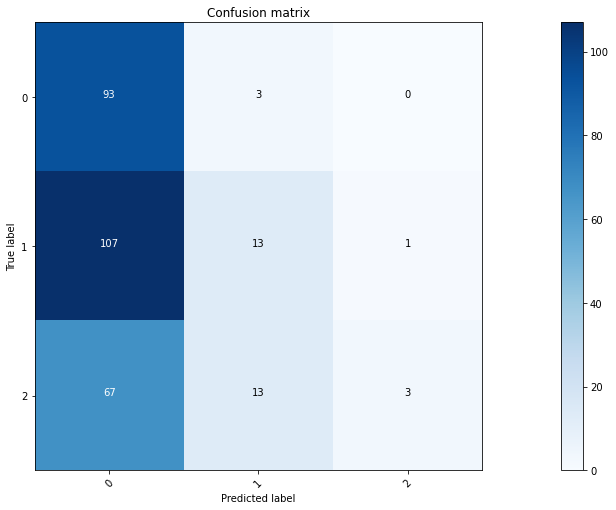

In [87]:
# Plotting confusion matrics
plt.subplots(figsize=(22==30,9)) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = CNN1.predict(X_test)
# Converting predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Converting validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# computing the confusion matrix
confusion_matrix = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_matrix, classes = range(3))

#Class 0 ,1 and 2
#Class 0 is Lung Opacity
#Class 1 is No Lung Opacity/Normal, the model has predicted mostly wrong in this case to the Target 0. Type 2 error
#Class 2 is Normal

In [88]:
# Adding to the dataframe

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = CNN1.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN1,0.385,0.363333,0.448276,0.107438,0.173333,121


In [93]:
reportData

{'0': {'precision': 0.34831460674157305,
  'recall': 0.96875,
  'f1-score': 0.5123966942148761,
  'support': 96},
 '1': {'precision': 0.4482758620689655,
  'recall': 0.10743801652892562,
  'f1-score': 0.17333333333333334,
  'support': 121},
 '2': {'precision': 0.75,
  'recall': 0.03614457831325301,
  'f1-score': 0.0689655172413793,
  'support': 83},
 'accuracy': 0.36333333333333334,
 'macro avg': {'precision': 0.5155301562701795,
  'recall': 0.3707775316140596,
  'f1-score': 0.2515651815965296,
  'support': 300},
 'weighted avg': {'precision': 0.4997652718584528,
  'recall': 0.36333333333333334,
  'f1-score': 0.2529585130299864,
  'support': 300}}

### Iteration 2

In [252]:
history2 = CNN1.fit(X_train, 
                  y_train, 
                  epochs = 15, 
                  validation_data = (X_val,y_val),
                  batch_size = 80)

Epoch 1/15
18/18 [==============================] - 75s 4s/step - loss: 1.0219 - accuracy: 0.4414 - val_loss: 1.0491 - val_accuracy: 0.4167
Epoch 2/15
18/18 [==============================] - 76s 4s/step - loss: 1.0101 - accuracy: 0.4707 - val_loss: 1.0325 - val_accuracy: 0.5300
Epoch 3/15
18/18 [==============================] - 76s 4s/step - loss: 1.0017 - accuracy: 0.4829 - val_loss: 1.0027 - val_accuracy: 0.5067
Epoch 4/15
18/18 [==============================] - 75s 4s/step - loss: 1.0310 - accuracy: 0.4636 - val_loss: 1.0080 - val_accuracy: 0.4267
Epoch 5/15
18/18 [==============================] - 77s 4s/step - loss: 1.0084 - accuracy: 0.4743 - val_loss: 1.0214 - val_accuracy: 0.4667
Epoch 6/15
18/18 [==============================] - 77s 4s/step - loss: 0.9978 - accuracy: 0.4736 - val_loss: 0.9948 - val_accuracy: 0.4933
Epoch 7/15
18/18 [==============================] - 75s 4s/step - loss: 0.9877 - accuracy: 0.4721 - val_loss: 0.9785 - val_accuracy: 0.5167
Epoch 8/15
18/18 [==

In [307]:
## evalualting the accuracy , we have only got accuracy of 43-46% where as the training accuracy is around 60%
fcl_loss, fcl_accuracy = CNN1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

10/10 [==============================] - 4s 347ms/step - loss: 1.0797 - accuracy: 0.4233
Test loss: 1.0797219276428223
Test accuracy: 0.4233333468437195


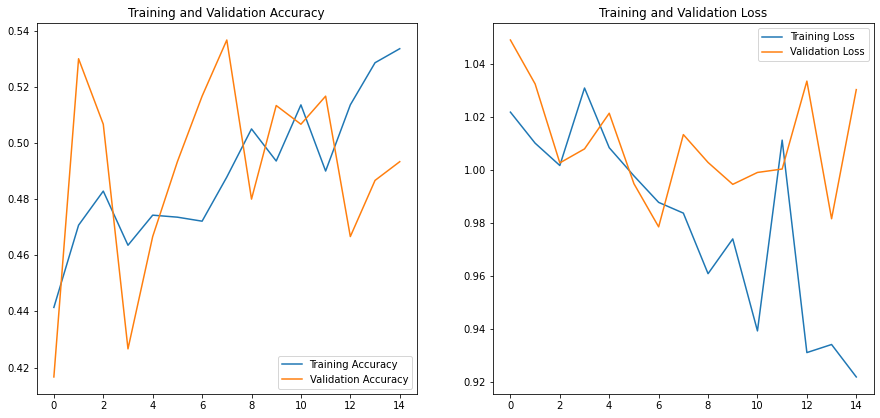

In [308]:
## PLottting the accuracy vs loss graph
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs_range = range(15)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



### Observations
##### Trainng accuracy is varying between at 44% and 53% . It is improving gradually.  validation accuracy is showing large variations with a big dip at epoch 3
##### Training loss is reducing over the epochs,  however it is not reducing in steady manner. there is a peak at epoch 11.  Validation loss is not reducing consistently

In [309]:
acc

[0.4414285719394684,
 0.470714271068573,
 0.4828571379184723,
 0.4635714292526245,
 0.47428572177886963,
 0.47357141971588135,
 0.4721428453922272,
 0.4878571331501007,
 0.5049999952316284,
 0.4935714304447174,
 0.5135714411735535,
 0.49000000953674316,
 0.5135714411735535,
 0.5285714268684387,
 0.5335714221000671]

In [310]:
Y_pred_classes

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], d

In [277]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_true, Y_pred_classes) 

In [278]:
confusion_matrix

array([[  0,  96,   0],
       [  0, 116,   5],
       [  0,  79,   4]], dtype=int64)

In [311]:
resultDF2 = createResultDf("CNN2",acc[-1],fcl_accuracy)
resultDF2

,Method,accuracy,Test Score
0,CNN2,0.533571,0.423333


In [312]:
# Adding to the dataframe

Y_truepred2 = np.argmax(y_test,axis = 1) 

Y_Pred2 = CNN1.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes2 = np.argmax(Y_Pred2,axis = 1) 

reportData = classification_report(Y_truepred2, Y_pred_classes2,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF2[data+"_"+subData] = reportData[data][subData]

resultDF2

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN2,0.533571,0.423333,0.398551,0.454545,0.42471,121


## Iteration 3

In [94]:
## Here we try changing kernel size, filters over the first 2 layers and the padding parameter 
# so that we can neglect the corners at the initial inputs. Also, keeping the dropout factor constant all over

def cnn_model3(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['categorical_accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 24, kernel_size = (8,8),padding = 'valid', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 24, kernel_size = (8,8),padding = 'valid', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))


  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'valid', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'valid', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.0001, rho=0.8, epsilon=1e-07, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model
  
 

In [106]:
# Model Summary
CNN2 = cnn_model3(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 128)       102528    
                                                                 
 conv2d_21 (Conv2D)          (None, 56, 56, 128)       409728    
                                                      

In [117]:
## Training for 10 epochs with batch size of 100
history3 = CNN2.fit(X_train, 
                  y_train, 
                  epochs = 20, 
                  validation_data = (X_val,y_val),
                  batch_size = 100)

Epoch 1/20
14/14 [==============================] - 131s 9s/step - loss: 1.1117 - accuracy: 0.3986 - val_loss: 1.0955 - val_accuracy: 0.3800
Epoch 2/20
14/14 [==============================] - 130s 9s/step - loss: 1.1313 - accuracy: 0.3521 - val_loss: 1.1016 - val_accuracy: 0.3800
Epoch 3/20
14/14 [==============================] - 129s 9s/step - loss: 1.1528 - accuracy: 0.3807 - val_loss: 1.0876 - val_accuracy: 0.3967
Epoch 4/20
14/14 [==============================] - 130s 9s/step - loss: 1.1267 - accuracy: 0.3600 - val_loss: 1.0627 - val_accuracy: 0.4700
Epoch 5/20
14/14 [==============================] - 129s 9s/step - loss: 1.2389 - accuracy: 0.3843 - val_loss: 1.0810 - val_accuracy: 0.4000
Epoch 6/20
14/14 [==============================] - 128s 9s/step - loss: 1.0818 - accuracy: 0.4000 - val_loss: 1.0697 - val_accuracy: 0.4867
Epoch 7/20
14/14 [==============================] - 129s 9s/step - loss: 1.1667 - accuracy: 0.3857 - val_loss: 1.0483 - val_accuracy: 0.4767
Epoch 8/20
14

In [265]:
## evalualting the accuracy , 
fcl_loss, fcl_accuracy = CNN3.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)


10/10 [==============================] - 3s 289ms/step - loss: 1.0477 - categorical_accuracy: 0.4433
Test loss: 1.0476820468902588
Test accuracy: 0.44333332777023315


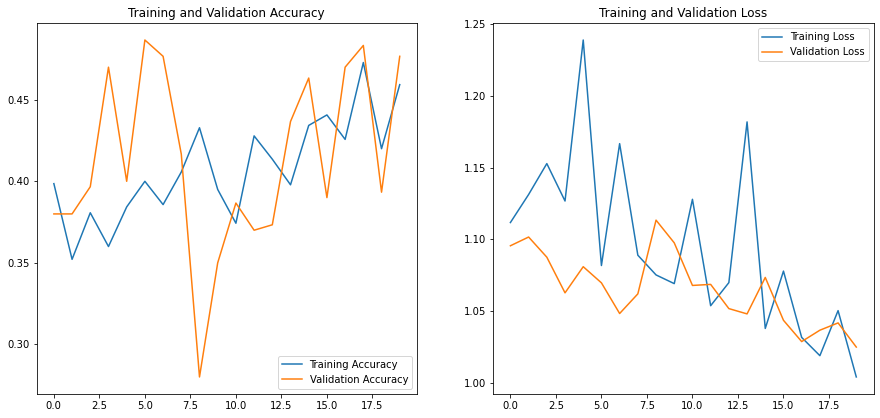

In [281]:
## PLottting the accuracy vs loss graph
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



### Observations
##### Trainng accuracy is varying between at 40% and 45% . It is improving gradually.  validation accuracy is showing large variations with a big dip at epoch 8
##### Training loss is reducing over the epochs,  however it is not reducing in steady manner.  Same is the case with Validation loss

In [282]:
acc

[0.3985714316368103,
 0.352142870426178,
 0.3807142972946167,
 0.36000001430511475,
 0.38428571820259094,
 0.4000000059604645,
 0.3857142925262451,
 0.4057142734527588,
 0.4328571557998657,
 0.39500001072883606,
 0.3742857277393341,
 0.4278571307659149,
 0.41357141733169556,
 0.397857129573822,
 0.4342857003211975,
 0.4407142996788025,
 0.42571428418159485,
 0.47285714745521545,
 0.41999998688697815,
 0.459285706281662]

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_true, Y_pred_classes) 

In [202]:
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset
Y_pred = CNN3.predict(X_test)
# Converting predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Converting validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# computing the confusion matrix
confusion_matrix = confusion_matrix(Y_true, Y_pred_classes) 
confusion_matrix


array([[21, 52, 23],
       [12, 55, 54],
       [ 5, 21, 57]], dtype=int64)

In [283]:
resultDF3 = createResultDf("CNN3",acc[-1],fcl_accuracy)
resultDF3

,Method,accuracy,Test Score
0,CNN3,0.459286,0.423333


In [284]:
# Adding to the dataframe

Y_truepred3 = np.argmax(y_test,axis = 1) 

Y_Pred3 = CNN3.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes3 = np.argmax(Y_Pred3,axis = 1) 

reportData = classification_report(Y_truepred3, Y_pred_classes3,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF3[data+"_"+subData] = reportData[data][subData]

resultDF3

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN3,0.459286,0.423333,0.429688,0.454545,0.441767,121


### Iteration 4

In [99]:
  
def cnn_model4(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))


  model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'valid', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'valid', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.35))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.40))


  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.8, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [100]:
CNN4 = cnn_model4(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 128)       102528    
                                                                 
 conv2d_15 (Conv2D)          (None, 56, 56, 128)       409728    
                                                      

In [101]:
## Training for 30 epochs with batch size of 30
history4 = CNN4.fit(X_train, 
                  y_train, 
                  epochs = 10, 
                  validation_data = (X_val,y_val),
                  batch_size = 100)

Epoch 1/10
14/14 [==============================] - 136s 10s/step - loss: 9.3989 - accuracy: 0.3514 - val_loss: 1.0918 - val_accuracy: 0.3800
Epoch 2/10
14/14 [==============================] - 133s 10s/step - loss: 1.2087 - accuracy: 0.3700 - val_loss: 1.0770 - val_accuracy: 0.4067
Epoch 3/10
14/14 [==============================] - 131s 9s/step - loss: 1.0928 - accuracy: 0.4086 - val_loss: 1.0721 - val_accuracy: 0.4000
Epoch 4/10
14/14 [==============================] - 130s 9s/step - loss: 1.4467 - accuracy: 0.3786 - val_loss: 1.0788 - val_accuracy: 0.3867
Epoch 5/10
14/14 [==============================] - 136s 10s/step - loss: 1.1207 - accuracy: 0.3600 - val_loss: 1.0903 - val_accuracy: 0.3800
Epoch 6/10
14/14 [==============================] - 135s 10s/step - loss: 1.1296 - accuracy: 0.3943 - val_loss: 1.0947 - val_accuracy: 0.3733
Epoch 7/10
14/14 [==============================] - 136s 10s/step - loss: 1.0786 - accuracy: 0.3843 - val_loss: 1.0686 - val_accuracy: 0.4667
Epoch 8/

In [301]:
## evalualting the accuracy , we have only got accuracy of 43-46% where as the training accuracy is around 60%
fcl_loss, fcl_accuracy = CNN4.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

10/10 [==============================] - 7s 704ms/step - loss: 1.0714 - accuracy: 0.4467
Test loss: 1.071401834487915
Test accuracy: 0.4466666579246521


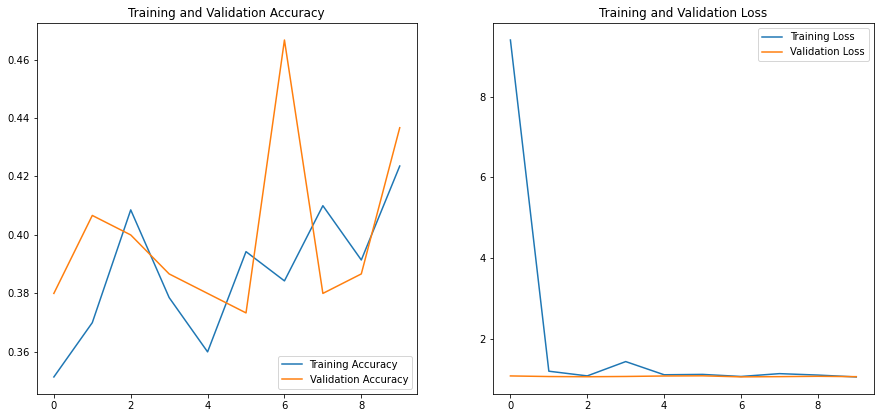

In [302]:
## PLottting the accuracy vs loss graph
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Observations
##### Trainng accuracy is varying between at 40% and 47%  (at 6th epoch) and falls further. Same is the case with validation accuracy
##### Training loss is reducing after 3 epochs and is stable post that. however there is slight increase between epoch 2 and 4.  Validation loss is steady

In [204]:
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset
Y_pred = CNN4.predict(X_test)
# Converting predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Converting validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# computing the confusion matrix
confusion_matrix = confusion_matrix(Y_true, Y_pred_classes) 
confusion_matrix

array([[17, 61, 18],
       [ 6, 72, 43],
       [ 4, 34, 45]], dtype=int64)

In [303]:
resultDF4 = createResultDf("CNN4",acc[-1],fcl_accuracy)
resultDF4

,Method,accuracy,Test Score
0,CNN4,0.423571,0.446667


In [304]:
# Adding to the dataframe

Y_truepred4 = np.argmax(y_test,axis = 1) 

Y_testPred4 = CNN4.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes4 = np.argmax(Y_testPred4,axis = 1) 

reportData = classification_report(Y_truepred4, Y_pred_classes4,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF4[data+"_"+subData] = reportData[data][subData]

resultDF4

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN4,0.423571,0.446667,0.431138,0.595041,0.5,121


### Iteration 5

In [111]:
# using adam optimizer
## Here we try changing kernel size, filters over the first 2 layers and the padding parameter 
# so that we can neglect the corners at the initial inputs. Also, keeping the dropout factor constant all over

def cnn_model5(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['categorical_accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 24, kernel_size = (8,8),padding = 'valid', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 24, kernel_size = (8,8),padding = 'valid', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))


  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'valid', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'valid', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))


  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = Adam(lr=0.0001, epsilon=1e-07, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model
  

In [112]:
CNN5 = cnn_model5(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 121, 121, 24)      4632      
                                                                 
 conv2d_31 (Conv2D)          (None, 114, 114, 24)      36888     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 57, 57, 24)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 57, 57, 24)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 57, 57, 32)        6944      
                                                                 
 conv2d_33 (Conv2D)          (None, 57, 57, 32)        9248      
                                                      

In [113]:
history5 = CNN5.fit(X_train, 
                  y_train, 
                  epochs = 20, 
                  validation_data = (X_val,y_val),
                  batch_size = 100)

Epoch 1/20
14/14 [==============================] - 87s 6s/step - loss: 4.8554 - categorical_accuracy: 0.3421 - val_loss: 1.0986 - val_categorical_accuracy: 0.4033
Epoch 2/20
14/14 [==============================] - 83s 6s/step - loss: 1.4089 - categorical_accuracy: 0.3379 - val_loss: 1.0829 - val_categorical_accuracy: 0.4400
Epoch 3/20
14/14 [==============================] - 86s 6s/step - loss: 1.1755 - categorical_accuracy: 0.3679 - val_loss: 1.0805 - val_categorical_accuracy: 0.4600
Epoch 4/20
14/14 [==============================] - 85s 6s/step - loss: 1.1450 - categorical_accuracy: 0.3564 - val_loss: 1.0781 - val_categorical_accuracy: 0.4300
Epoch 5/20
14/14 [==============================] - 81s 6s/step - loss: 1.1112 - categorical_accuracy: 0.3957 - val_loss: 1.0735 - val_categorical_accuracy: 0.4067
Epoch 6/20
14/14 [==============================] - 84s 6s/step - loss: 1.1079 - categorical_accuracy: 0.3771 - val_loss: 1.0678 - val_categorical_accuracy: 0.4200
Epoch 7/20
14/14

In [288]:
## evalualting the accuracy , we have only got accuracy of 43-46% where as the training accuracy is around 60%
fcl_loss, fcl_accuracy = CNN5.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

10/10 [==============================] - 3s 306ms/step - loss: 0.9936 - categorical_accuracy: 0.5733
Test loss: 0.9936462640762329
Test accuracy: 0.5733333230018616


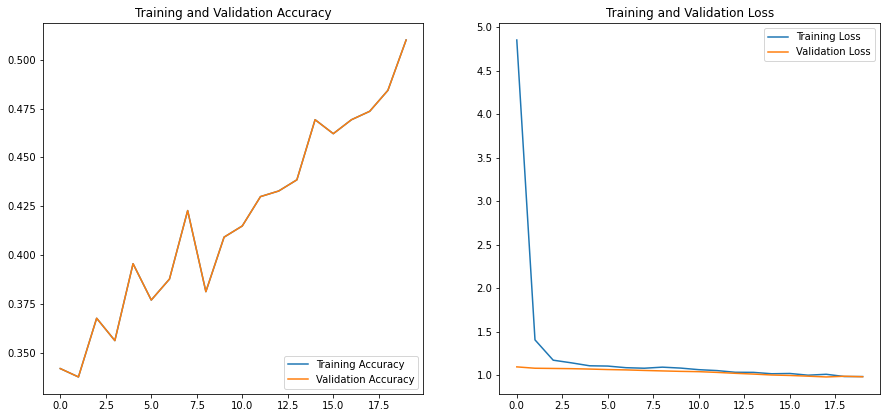

In [289]:
## PLottting the accuracy vs loss graph
acc = history5.history['categorical_accuracy']
val_acc = history5.history['categorical_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']
epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



### Observations
##### Trainng accuracy is improving gradually till 20th epoch. Increasing no of epochs can be helpful
##### Validateion loss is reducing after 3 epochs and is stable post that 

In [206]:
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset
Y_pred = CNN5.predict(X_test)
# Converting predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Converting validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# computing the confusion matrix
confusion_matrix = confusion_matrix(Y_true, Y_pred_classes) 
confusion_matrix

array([[58, 22, 16],
       [29, 57, 35],
       [ 7, 19, 57]], dtype=int64)

In [290]:
resultDF5 = createResultDf("CNN5",acc[-1],fcl_accuracy)
resultDF5

,Method,accuracy,Test Score
0,CNN5,0.51,0.573333


In [291]:
# Adding to the dataframe

Y_truepred5 = np.argmax(y_test,axis = 1) 

Y_testPred5 = CNN5.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes5 = np.argmax(Y_testPred5,axis = 1) 

reportData = classification_report(Y_truepred5, Y_pred_classes5,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF5[data+"_"+subData] = reportData[data][subData]

resultDF5

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN5,0.51,0.573333,0.581633,0.471074,0.520548,121


### Iteration 6

In [114]:
# using adam optimizer with learning rate = 0.001
## Here we try changing kernel size, filters over the first 2 layers and the padding parameter 
# so that we can neglect the corners at the initial inputs. Also, keeping the dropout factor constant all over

def cnn_model6(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['categorical_accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 24, kernel_size = (8,8),padding = 'valid', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 24, kernel_size = (8,8),padding = 'valid', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))


  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'valid', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'valid', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))


  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = Adam(lr=0.001, epsilon=1e-07, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model
  

In [115]:
CNN6 = cnn_model6(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 121, 121, 24)      4632      
                                                                 
 conv2d_37 (Conv2D)          (None, 114, 114, 24)      36888     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 57, 57, 24)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 57, 57, 24)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 57, 57, 32)        6944      
                                                                 
 conv2d_39 (Conv2D)          (None, 57, 57, 32)        9248      
                                                      

In [116]:
history6 = CNN6.fit(X_train, 
                  y_train, 
                  epochs = 20, 
                  validation_data = (X_val,y_val),
                  batch_size = 100)

Epoch 1/20
14/14 [==============================] - 84s 6s/step - loss: 6.2383 - categorical_accuracy: 0.3464 - val_loss: 1.1015 - val_categorical_accuracy: 0.3800
Epoch 2/20
14/14 [==============================] - 82s 6s/step - loss: 1.0988 - categorical_accuracy: 0.3921 - val_loss: 1.0986 - val_categorical_accuracy: 0.3800
Epoch 3/20
14/14 [==============================] - 81s 6s/step - loss: 1.0940 - categorical_accuracy: 0.3929 - val_loss: 1.0968 - val_categorical_accuracy: 0.3800
Epoch 4/20
14/14 [==============================] - 82s 6s/step - loss: 1.0914 - categorical_accuracy: 0.3943 - val_loss: 1.0971 - val_categorical_accuracy: 0.3800
Epoch 5/20
14/14 [==============================] - 81s 6s/step - loss: 1.0902 - categorical_accuracy: 0.3929 - val_loss: 1.0961 - val_categorical_accuracy: 0.3800
Epoch 6/20
14/14 [==============================] - 82s 6s/step - loss: 1.0882 - categorical_accuracy: 0.3971 - val_loss: 1.0972 - val_categorical_accuracy: 0.3800
Epoch 7/20
14/14

In [292]:
## evalualting the accuracy , we have only got accuracy of 43-46% where as the training accuracy is around 60%
fcl_loss, fcl_accuracy = CNN6.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

10/10 [==============================] - 3s 295ms/step - loss: 1.0898 - categorical_accuracy: 0.4000
Test loss: 1.089840292930603
Test accuracy: 0.4000000059604645


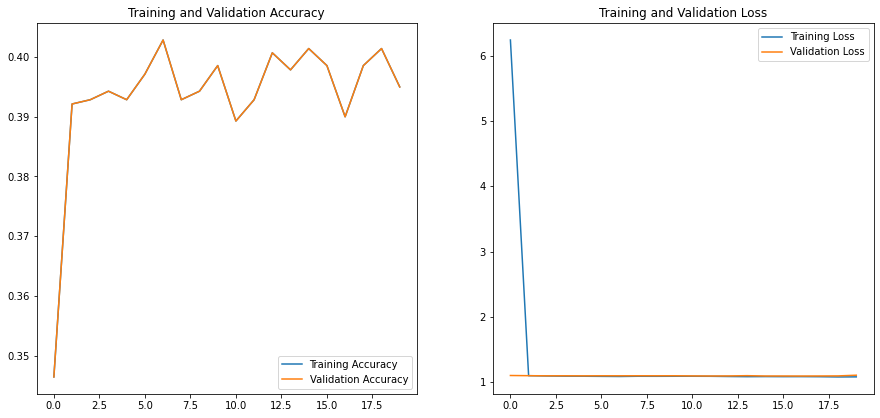

In [293]:
## PLottting the accuracy vs loss graph
acc = history6.history['categorical_accuracy']
val_acc = history6.history['categorical_accuracy']
loss = history6.history['loss']
val_loss = history6.history['val_loss']
epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



### Observations
##### Trainng accuracy is at 40% after 5 epochs and there is no improvement
##### Validateion loss is reducing after 3 epochs and is stable post that 

In [220]:
from sklearn.metrics import confusion_matrix
# Predict the value from the validation dataset
Y_pred = CNN6.predict(X_test)
# Converting predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Converting validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# computing the confusion matrix
confusion_matrix = confusion_matrix(Y_true, Y_pred_classes) 
confusion_matrix

array([[  0,  96,   0],
       [  0, 116,   5],
       [  0,  79,   4]], dtype=int64)

In [294]:
acc

[0.3464285731315613,
 0.3921428620815277,
 0.3928571343421936,
 0.3942857086658478,
 0.3928571343421936,
 0.39714285731315613,
 0.4028571546077728,
 0.3928571343421936,
 0.3942857086658478,
 0.3985714316368103,
 0.38928571343421936,
 0.3928571343421936,
 0.40071427822113037,
 0.397857129573822,
 0.40142858028411865,
 0.3985714316368103,
 0.38999998569488525,
 0.3985714316368103,
 0.40142858028411865,
 0.39500001072883606]

In [295]:
resultDF6 = createResultDf("CNN6",acc[-1],fcl_accuracy)
resultDF6

,Method,accuracy,Test Score
0,CNN6,0.395,0.4


In [296]:
# Adding to the dataframe

Y_truepred6 = np.argmax(y_test,axis = 1) 

Y_testPred6 = CNN6.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes6 = np.argmax(Y_testPred6,axis = 1) 

reportData = classification_report(Y_truepred6, Y_pred_classes6,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF6[data+"_"+subData] = reportData[data][subData]

resultDF6

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN6,0.395,0.4,0.398625,0.958678,0.563107,121


In [297]:
# compiling the data into single DF

In [313]:
resultDF_Final = pd.concat([resultDF, resultDF2, resultDF3, resultDF4, resultDF5,resultDF6], axis=0)

In [314]:
resultDF_Final

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN1,0.435714,0.413333,0.398625,0.958678,0.563107,121
0,CNN2,0.533571,0.423333,0.398551,0.454545,0.424710,121
0,CNN3,0.459286,0.423333,0.429688,0.454545,0.441767,121
0,CNN4,0.423571,0.446667,0.431138,0.595041,0.500000,121
0,CNN5,0.510000,0.573333,0.581633,0.471074,0.520548,121
0,CNN6,0.395000,0.400000,0.398625,0.958678,0.563107,121


### Summary:
    1) We have executed 6 iterations with various combination optimizer, learning rate, epochs and batch size.
    2) Accuracy is betwenn 39 and 53%. However there is a huge variation in recall which we need to analyse further
    3) We will also experiement with other parameters like early stop, decay, row, epsilon and train on larger dataset
    4) Next phasae we will also try trnasfer learning and compare the results with the six iterations we have done so far.
    

**End of interim project**